# Import Library

In [37]:
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GATConv, GCNConv
from spektral.transforms import AdjToSpTensor, LayerPreprocess

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from models_new import (
    GCN,
    InceptionGCN,
    InceptionBlock,
)
    
from utils import (
    seed_everything, 
    limit_data, 
    encode_label, 
    normalize_Adj,
    draw_history,
    plot_tSNE,
)
import config as C

#### Set Seed

In [2]:
seed_everything(C.SEED)

# Load Data

In [3]:
dataset = Citation(
    "cora", normalize_x=True, transforms=[LayerPreprocess(GATConv), AdjToSpTensor()]
)


def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)


weights_tr, weights_va, weights_te = (
    mask_to_weights(mask)
    for mask in (dataset.mask_tr, dataset.mask_va, dataset.mask_te)
)

classes = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory']

Pre-processing node features


/home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [4]:
loader_all = SingleLoader(dataset)

loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)
loader_te = SingleLoader(dataset, sample_weights=weights_te)

x, y, w = next(iter(loader_te))
x[0].shape, y.shape, w.shape

((2708, 1433), (2708, 7), (2708,))

# GCN

#### Build Model

In [5]:
gcn_model = GCN(C.GCN_filters, C.dropout)

gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/200
1/1 [==============================] - 1s 925ms/step - loss: 1.9769 - acc: 0.1357 - val_loss: 1.9002 - val_acc: 0.2980
Epoch 2/200
1/1 [==============================] - 0s 31ms/step - loss: 1.8890 - acc: 0.3071 - val_loss: 1.8468 - val_acc: 0.2940
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 1.7757 - acc: 0.4143 - val_loss: 1.7819 - val_acc: 0.3400
Epoch 4/200
1/1 [==============================] - 0s 34ms/step - loss: 1.7178 - acc: 0.3714 - val_loss: 1.7277 - val_acc: 0.3620
Epoch 5/200
1/1 [==============================] - 0s 31ms/step - loss: 1.6729 - acc: 0.4143 - val_loss: 1.6602 - val_acc: 0.3980
Epoch 6/200
1/1 [==============================] - 0s 32ms/step - loss: 1.5081 - acc: 0.6071 - val_loss: 1.6185 - val_acc: 0.4280
Epoch 7/200
1/1 [==============================] - 0s 32ms/step - loss: 1.4587 - acc: 0.5571 - val_loss: 1.5764 - val_acc: 0.4760
Epoch 8/200
1/1 [==============================] - 0s 29ms/step - loss: 1.5132 - acc: 0.5

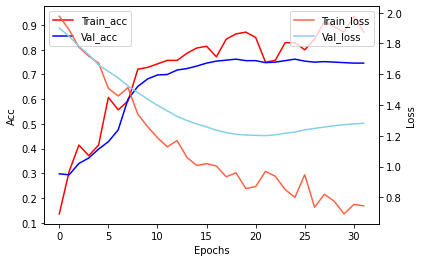

In [6]:
gcn_history = gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=C.epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=C.es_patience, restore_best_weights=True)]
)

draw_history(gcn_history, 'GCN', issave=False)

#### Evaluate

In [7]:
y_pred = gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.63      0.80      0.71       351
    Genetic_Algorithms       0.77      0.83      0.80       217
       Neural_Networks       0.92      0.83      0.87       418
 Probabilistic_Methods       0.86      0.72      0.78       818
Reinforcement_Learning       0.77      0.81      0.79       426
         Rule_Learning       0.80      0.77      0.78       298
                Theory       0.61      0.78      0.69       180

              accuracy                           0.78      2708
             macro avg       0.77      0.79      0.77      2708
          weighted avg       0.80      0.78      0.78      2708



#### Visualization

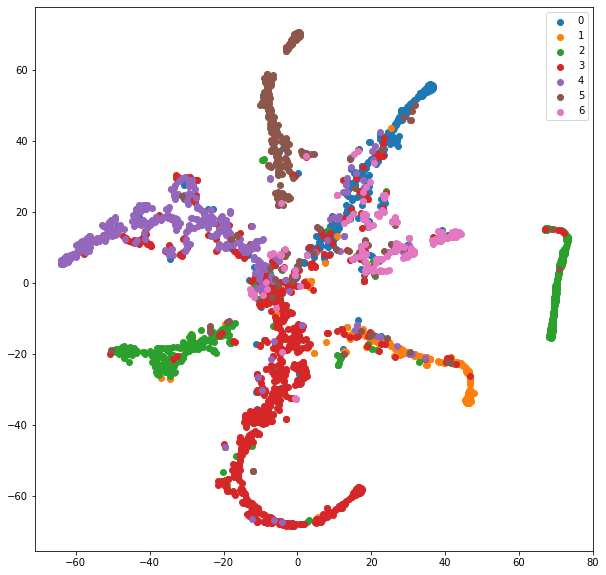

In [8]:
activations = gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(y_all, x_tsne)

# Inception GCN

#### Build Model

In [9]:
inception_gcn_model = InceptionGCN(C.dropout)

inception_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

Epoch 1/1000
Instructions for updating:
Use `tf.linalg.matmul` instead
1/1 [==============================] - 1s 649ms/step - loss: 622.1407 - acc: 0.1571 - val_loss: 591.1616 - val_acc: 0.0820
Epoch 2/1000
1/1 [==============================] - 0s 119ms/step - loss: 486.7321 - acc: 0.1714 - val_loss: 220.4763 - val_acc: 0.1880
Epoch 3/1000
1/1 [==============================] - 0s 104ms/step - loss: 100.0731 - acc: 0.1929 - val_loss: 87.9161 - val_acc: 0.1880
Epoch 4/1000
1/1 [==============================] - 0s 111ms/step - loss: 155.5803 - acc: 0.2143 - val_loss: 90.7871 - val_acc: 0.1500
Epoch 5/1000
1/1 [==============================] - 0s 120ms/step - loss: 117.6910 - acc: 0.1357 - val_loss: 53.9099 - val_acc: 0.1520
Epoch 6/1000
1/1 [==============================] - 0s 105ms/step - loss: 53.3564 - acc: 0.1357 - val_loss: 39.3435 - val_acc: 0.1560
Epoch 7/1000
1/1 [==============================] - 0s 113ms/step - loss: 61.9734 - acc: 0.1357 - val_loss: 28.0604 - val_acc: 0.16

1/1 [==============================] - 0s 105ms/step - loss: 1.6756 - acc: 0.4714 - val_loss: 1.6974 - val_acc: 0.5720
Epoch 61/1000
1/1 [==============================] - 0s 104ms/step - loss: 1.6624 - acc: 0.4643 - val_loss: 1.6654 - val_acc: 0.5600
Epoch 62/1000
1/1 [==============================] - 0s 103ms/step - loss: 1.6703 - acc: 0.4714 - val_loss: 1.6400 - val_acc: 0.5500
Epoch 63/1000
1/1 [==============================] - 0s 104ms/step - loss: 1.6357 - acc: 0.4571 - val_loss: 1.6394 - val_acc: 0.5500
Epoch 64/1000
1/1 [==============================] - 0s 105ms/step - loss: 1.6223 - acc: 0.4357 - val_loss: 1.6500 - val_acc: 0.5400
Epoch 65/1000
1/1 [==============================] - 0s 110ms/step - loss: 1.7768 - acc: 0.4571 - val_loss: 1.6366 - val_acc: 0.5520
Epoch 66/1000
1/1 [==============================] - 0s 113ms/step - loss: 1.6281 - acc: 0.4786 - val_loss: 1.6218 - val_acc: 0.5620
Epoch 67/1000
1/1 [==============================] - 0s 109ms/step - loss: 1.6363 -

1/1 [==============================] - 0s 106ms/step - loss: 1.3097 - acc: 0.5929 - val_loss: 1.4883 - val_acc: 0.5860
Epoch 122/1000
1/1 [==============================] - 0s 103ms/step - loss: 1.3580 - acc: 0.5786 - val_loss: 1.4789 - val_acc: 0.5940
Epoch 123/1000
1/1 [==============================] - 0s 110ms/step - loss: 1.3132 - acc: 0.6429 - val_loss: 1.4690 - val_acc: 0.6060
Epoch 124/1000
1/1 [==============================] - 0s 107ms/step - loss: 1.2776 - acc: 0.6000 - val_loss: 1.4571 - val_acc: 0.6080
Epoch 125/1000
1/1 [==============================] - 0s 109ms/step - loss: 1.2862 - acc: 0.6571 - val_loss: 1.4485 - val_acc: 0.6180
Epoch 126/1000
1/1 [==============================] - 0s 100ms/step - loss: 1.2637 - acc: 0.5857 - val_loss: 1.4429 - val_acc: 0.6260
Epoch 127/1000
1/1 [==============================] - 0s 104ms/step - loss: 1.2409 - acc: 0.6357 - val_loss: 1.4391 - val_acc: 0.6360
Epoch 128/1000
1/1 [==============================] - 0s 104ms/step - loss: 1

1/1 [==============================] - 0s 110ms/step - loss: 0.9038 - acc: 0.8429 - val_loss: 1.4842 - val_acc: 0.7000
Epoch 183/1000
1/1 [==============================] - 0s 104ms/step - loss: 0.9194 - acc: 0.8000 - val_loss: 1.4830 - val_acc: 0.6960
Epoch 184/1000
1/1 [==============================] - 0s 107ms/step - loss: 0.9470 - acc: 0.8071 - val_loss: 1.4858 - val_acc: 0.6920
Epoch 185/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.9177 - acc: 0.8143 - val_loss: 1.4794 - val_acc: 0.6960
Epoch 186/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.9250 - acc: 0.7857 - val_loss: 1.4756 - val_acc: 0.7020
Epoch 187/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.9015 - acc: 0.8214 - val_loss: 1.4731 - val_acc: 0.7060
Epoch 188/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.9099 - acc: 0.8071 - val_loss: 1.4738 - val_acc: 0.7120
Epoch 189/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.9

1/1 [==============================] - 0s 97ms/step - loss: 0.7995 - acc: 0.8429 - val_loss: 1.5546 - val_acc: 0.7120
Epoch 244/1000
1/1 [==============================] - 0s 110ms/step - loss: 0.7828 - acc: 0.8214 - val_loss: 1.5656 - val_acc: 0.7140
Epoch 245/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.7825 - acc: 0.8714 - val_loss: 1.5796 - val_acc: 0.7100
Epoch 246/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.7681 - acc: 0.8643 - val_loss: 1.5955 - val_acc: 0.7080
Epoch 247/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.7709 - acc: 0.8571 - val_loss: 1.6136 - val_acc: 0.7100
Epoch 248/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.8062 - acc: 0.8357 - val_loss: 1.6267 - val_acc: 0.7120
Epoch 249/1000
1/1 [==============================] - 0s 111ms/step - loss: 0.8512 - acc: 0.8143 - val_loss: 1.6304 - val_acc: 0.7100
Epoch 250/1000
1/1 [==============================] - 0s 110ms/step - loss: 0.7

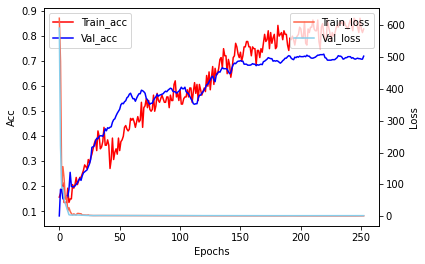

In [10]:
inception_gcn_history = inception_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(inception_gcn_history, 'InceptionGCN', issave=False)

#### Evaluate

In [11]:
y_pred = inception_gcn_model.predict(loader_te.load(),
                           steps=loader_te.steps_per_epoch)
report = classification_report(np.argmax(y, axis=1),
                     np.argmax(y_pred, axis=1),
                     target_names=classes)
print(f'LOG >>> Inception GCN Classification Report:\n{report}')

LOG >>> Inception GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.69      0.56      0.62       351
    Genetic_Algorithms       0.76      0.76      0.76       217
       Neural_Networks       0.85      0.86      0.86       418
 Probabilistic_Methods       0.84      0.66      0.74       818
Reinforcement_Learning       0.68      0.83      0.74       426
         Rule_Learning       0.58      0.74      0.65       298
                Theory       0.43      0.59      0.50       180

              accuracy                           0.72      2708
             macro avg       0.69      0.71      0.70      2708
          weighted avg       0.74      0.72      0.72      2708



#### Visualization

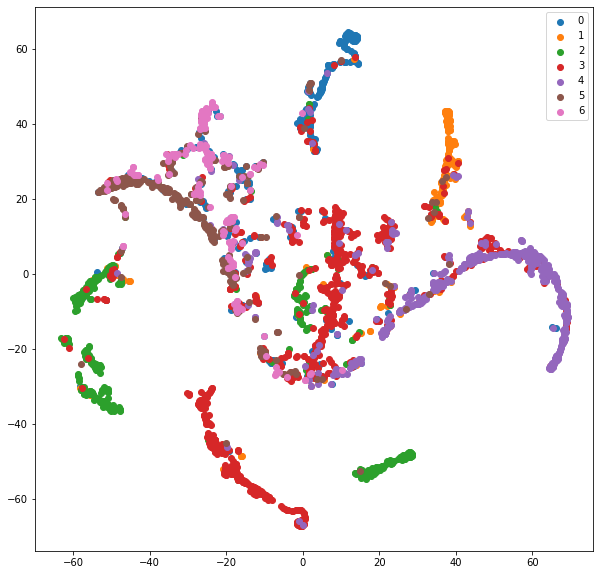

In [12]:
activations = inception_gcn_model.predict(loader_all.load(),
                 steps=loader_all.steps_per_epoch)

_, y_all = next(iter(loader_all))

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(y_all, x_tsne)

# Residual GCN

#### Build Model

In [42]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self,
                filters,
                activation=None,
                isLast=False,
                isinception=False,
                isgate=False,
                isattention=False,
                attn_heads=1,
                dropout=0.5,
                concat_heads=False,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                attn_kernel_regularizer=None,
                bias_regularizer=None):
        super(ResidualBlock, self).__init__()
        
        self.filters = filters
        self.activation = activations.get(activation)
        
        self.isLast = isLast
        self.isgate = isgate
        self.attn_heads = attn_heads
        self.concat_heads = concat_heads
        
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.attn_kernel_regularizer = regularizers.get(attn_kernel_regularizer)
        
        if isinception:
            self.layer = InceptionBlock(filters, activation=self.activation)
        elif isattention:
            self.layer = GATConv(filters,
                                attn_heads=self.attn_heads,
                                concat_heads=self.concat_heads,
                                dropout_rate=dropout,
                                activation=self.activation,
                                kernel_regularizer=self.kernel_regularizer,
                                attn_kernel_regularizer=self.attn_kernel_regularizer,
                                bias_regularizer=self.bias_regularizer
                                )
        else:
            self.layer = GCNConv(filters,
                                activation=self.activation,
                                use_bias=False,
                                kernel_regularizer=self.kernel_regularizer)
        
        self.dense = tf.keras.layers.Dense(filters, use_bias=False)
        
    def build(self, input_shape):
        print(f'LOG >> input shape: {input_shape}')
        self.weight_in = self.add_weight(name='weight_in',
                                       shape=[input_shape[0][0], input_shape[0][0]],
                                       initializer=self.kernel_initializer,
                                       regularizer=self.kernel_regularizer,
                                       trainable=True)
        self.bias_in = self.add_weight(name='bias_in',
                                       shape=[input_shape[0][0], self.filters],
                                       initializer=self.bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       trainable=True)
        self.weight_out = self.add_weight(name='weight_out',
                                       shape=[input_shape[0][0], input_shape[0][0]],
                                       initializer=self.kernel_initializer,
                                       regularizer=self.kernel_regularizer,
                                       trainable=True)
        self.bias_out = self.add_weight(name='bias_out',
                                       shape=[input_shape[0][0], self.filters],
                                       initializer=self.bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       trainable=True)
        
    def call(self, input_tensor, training=False):
        x, A = input_tensor
        
        f = self.layer([x, A])
        
        if tf.shape(x)[-1] != tf.shape(f)[-1]:
            x = self.dense(x)
            
        if self.isgate:
            z = self.get_coefficient(x, f)
            output = tf.matt.multiply(z, f) + tf.math.multiply(1 - z, x)
        else:
            output = x + f
        
        if self.isLast:
            output = tf.nn.softmax(output)
        else:
            output = self.activation(output)
        
        return output
            
    def get_coefficient(self, x, f):
        x = tf.matmul(self.weight_in, x) + self.bias_in
        f = tf.matmul(self.weight_out, f) + self.bias_out
        output = tf.nn.sigmoid(x + f)
        return output 

In [43]:
class ResidualGCN(tf.keras.Model):
    def __init__(self,
                dropout,
                ):
        super(ResidualGCN, self).__init__(name='ResidualGCN')
        
        self.dropout_1 = Dropout(dropout)
        self.resBlock_1 = ResidualBlock(C.GCN_filters,
                                        activation='relu',
                                        isinception=False,
                                        isgate=False,
                                        isattention=False)
        self.dropout_2 = Dropout(dropout)
        self.resBlock_2 = ResidualBlock(C.num_classes,
                                        activation='relu',
                                        isLast=True,
                                        isinception=False,
                                        isgate=False,
                                        isattention=False)
        
    def call(self, input_tensor, training=False):
        x, A = input_tensor
        x = self.dropout_1(x)
        x = self.resBlock_1([x, A])
        x = self.dropout_2(x)
        output = self.resBlock_1([x, A])
        return output

In [44]:
residual_gcn_model = ResidualGCN(C.dropout)

residual_gcn_model.compile(
    optimizer = Adam(lr=C.learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

#### Training

In [45]:
residual_gcn_history = residual_gcn_model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=1000,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
)

draw_history(residual_gcn_history, 'ResidualGCN', issave=False)

Epoch 1/1000
LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]


ValueError: in user code:

    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-43-b0882bdeef9d>:26 call  *
        output = self.resBlock_1([x, A])
    <ipython-input-21-04b06ab6f2da>:80 call  *
        f = self.layer([x, A])
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/spektral/layers/convolutional/gcn_conv.py:102 call  *
        output = K.dot(x, self.kernel)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:1898 dot
        out = math_ops.matmul(x, y)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3315 matmul
        a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:5550 mat_mul
        name=name)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:592 _create_op_internal
        compute_device)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3536 _create_op_internal
        op_def=op_def)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2016 __init__
        control_input_ops, op_def)
    /home/sungjin/anaconda3/envs/spektral/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 16 and 1433 for '{{node ResidualGCN/residual_block_17/gcn_conv_28/MatMul_1}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](ResidualGCN/dropout_22/dropout/Mul_1, ResidualGCN/residual_block_17/gcn_conv_28/MatMul_1/ReadVariableOp)' with input shapes: [2708,16], [1433,16].


In [33]:
r = ResidualGCN(C.dropout)
r(x)

LOG >> input shape: [TensorShape([2708, 1433]), TensorShape([2708, 2708])]


InvalidArgumentError: Matrix size-incompatible: In[0]: [2708,16], In[1]: [1433,16] [Op:MatMul]